In [1]:
import numpy as np
import qilisdk
import qutip as qt
import matplotlib.pyplot as plt
import sys

In [2]:
sys.path.append('/Users/omichel/Desktop/qilimanjaro/projects/retech/retech_2025/src')

import hamiltonian
import dynamics
import plots
import estimator

# Generate data to feed into VQE

In [3]:
def create_random_hamiltonian(Nqubits, min_weight, max_weight):
    H_out = hamiltonian.QutipHamiltonian(Nqubits)
    single_x_weights = np.random.uniform(min_weight, max_weight, size=Nqubits)
    single_z_weights = np.random.uniform(min_weight, max_weight, size=Nqubits)

    interaction_weights = np.random.uniform(min_weight, max_weight, size=int(Nqubits*(Nqubits-1)/2))
    interaction_counter = 0
    for i in range(Nqubits):
        H_out.add_x_field(i, single_x_weights[i])
        H_out.add_z_field(i, single_z_weights[i])

        for j in range(i+1, Nqubits):
            H_out.add_ZZ_term(i, j, interaction_weights[interaction_counter])
            interaction_counter+=1
    
    return H_out

In [4]:
H_test = create_random_hamiltonian(1, -1.0, 1.0)

print(H_test.H)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.25918854 -0.14777451]
 [-0.14777451 -0.25918854]]


In [5]:
size = 2

H_fix = hamiltonian.QutipHamiltonian(size)

H_fix.add_z_field(0, 1)
H_fix.add_z_field(1, 0.8)
H_fix.add_x_field(0, 0.5)
H_fix.add_x_field(1, 0.7)
H_fix.add_ZZ_term(0, 1, 0.45)
print(H_fix.H)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 2.25  0.7   0.5   0.  ]
 [ 0.7  -0.25  0.    0.5 ]
 [ 0.5   0.   -0.65  0.7 ]
 [ 0.    0.5   0.7  -1.35]]


In [6]:
psi_0 = dynamics.initialize_down_state(size)

print(psi_0)

Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]


In [7]:
ti = 0
tf = 2
nsteps = 1000

sim = dynamics.time_evolution(H_fix, psi_0, ti, tf, nsteps)

In [8]:
observables = dynamics.calculate_expectation_values(sim, H_fix)

In [9]:
def calculate_probability(state, qubit_index, basis='Z', shots=10000):
    # Measure first qubit
    outcomes, probs =dynamics.measure_qubit(state, qubit_index, basis, shots)
    counts = np.bincount(outcomes, minlength=2)
    average = (counts[0] * 1 + counts[1] * (-1)) / shots

    return outcomes, counts, average

In [10]:
print(observables['Sz'][-1])
print(observables['Sx'][-1])

[0.87149432 0.84794951]
[0.29439019 0.23333651]


In [11]:
outcomes_z_0, counts_z_0, average_z_0 = calculate_probability(sim.states[-1], 0, 'Z', 100000)
outcomes_x_0, counts_x_0, average_x_0 = calculate_probability(sim.states[-1], 0, 'X', 100000)

outcomes_z_1, counts_z_1, average_z_1 = calculate_probability(sim.states[-1], 1, 'Z', 100000)
outcomes_x_1, counts_x_1, average_x_1 = calculate_probability(sim.states[-1], 1, 'X', 100000)

print([average_z_0, average_z_1])
print([average_x_0, average_x_1])

[np.float64(0.8716), np.float64(0.84788)]
[np.float64(0.29612), np.float64(0.23188)]


# VQE in QiliSKD

In [47]:
from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, M, U1, CNOT, U2, U3, CZ, RX, RZ, H
from qilisdk.digital.ansatz import HardwareEfficientAnsatz
from qilisdk.optimizers import SciPyOptimizer
from qilisdk.functionals.variational_program import VariationalProgram
from qilisdk.functionals.sampling import Sampling, SamplingResult
from qilisdk.functionals.time_evolution import TimeEvolution
from scipy.optimize import minimize

from qilisdk.core import Model, BinaryVariable
from qilisdk.cost_functions import ModelCostFunction

In [20]:
# Usage example
# Initialize estimator
log_estimator = estimator.NegativeLogLikelihoodEstimator()

# Example true state (evolved under H_T)
true_state = sim.states[-1]

# Generate measurement dataset from true state
M = 100  # Number of measurement repeats
dataset = log_estimator.generate_measurement_dataset(true_state, 'Z', M)



## Just for test purposes
# Example estimated state (from your NODE/VQE)
estimated_state = qt.tensor([(0.9 * qt.basis(2, 0) + 0.5 * qt.basis(2, 1)).unit(),
                               qt.basis(2, 0)])
# Compute negative log-likelihood loss
loss = log_estimator.negative_log_likelihood(estimated_state, dataset, 'Z')
print(f"Negative Log-Likelihood Loss: {loss:.4f}")

Negative Log-Likelihood Loss: 1.8972


## VQE ansatz

In [40]:
def generate_connectivity_list(size, mode = 'ATA', boundary = 'open'):
    connectivity = []
    if mode == 'ATA':
        for i in range(size):
            for j in range(i+1, size):    
                connectivity.append([i,j])

    elif mode == 'NN':
        for i in range(size-1):
            connectivity.append([i, i+1])

    if boundary == 'closed' and size > 2:
        connectivity.append([size-1, 0])

    return connectivity

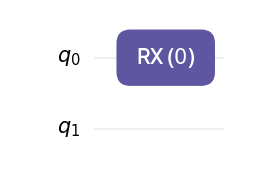

In [62]:
c = Circuit(nqubits=2)


c.add(RX(0, theta=0))

c.draw()

In [67]:
# Build a parameterized circuit ansatz:
def build_ansatz_circuit(params, nqubits, layers, connectivity):
    """
    params layout:
      - per layer:
         - for each qubit: RX angle, RZ angle  -> 2*nqubits
         - for each entangler pair: CRZ angle -> len(connectivity)
      total params per layer = 2*nqubits + len(connectivity)
    params should be a flat 1D array of length layers * (2*nqubits + len(connectivity))
    """
    per_layer = 2 * nqubits + len(connectivity)
    assert params.size == layers * per_layer, "params size mismatch"
    c = Circuit(nqubits=nqubits)
    p = params.reshape((layers, per_layer))
    for L in range(layers):
        # single-qubit rotations
        for q in range(nqubits):
            rx_angle = p[L, 2*q]
            rz_angle = p[L, 2*q + 1]
            c.add(RX(q, theta=rx_angle))
            c.add(RZ(q, phi=rz_angle))
        # entanglers: controlled-RZ via decomposition
        ent_start = 2*nqubits
        for k, (control, target) in enumerate(connectivity):
            lam = p[L, ent_start + k]
            c.add(RZ(target, phi=lam).controlled(control))
            
            # decomposition: CRZ(lam) = (I⊗RZ(lam/2)) · CNOT · (I⊗RZ(-lam/2)) · CNOT  (up to global phase)
            # c.add(RZ, target, params=[lam/2])
            # c.add(CNOT, control, target)
            # c.add(RZ, target, params=[-lam/2])
            # c.add(CNOT, control, target)
    return c

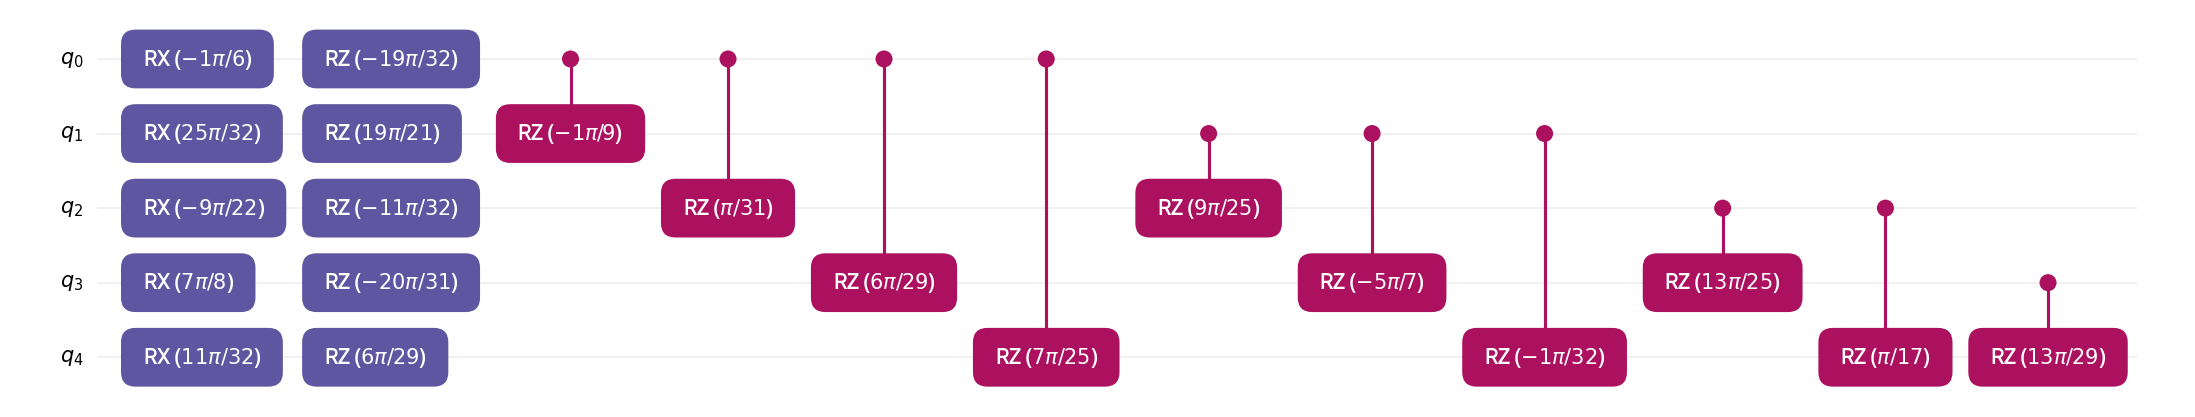

In [71]:
nqubits = 5
layers = 1

connectivity = generate_connectivity_list(nqubits)
per_layer = 2*nqubits + len(connectivity)
params = np.random.uniform(-np.pi, np.pi, size=(layers * per_layer))


circuit = build_ansatz_circuit(np.array(params), nqubits, layers, connectivity)

circuit.draw()

In [ ]:
# function that runs circuit on Qutip backend and returns Qutip state (Qobj)
def get_state_from_circuit(circuit, backend=None):
    if backend is None:
        backend = QutipBackend()
    res = backend.run(circuit)   # backend.run returns a result object
    # Try common result attributes to extract final state vector or Qobj
    if hasattr(res, "statevector"):
        vec = res.statevector
        return qt.Qobj(vec, dims=[[2]*circuit.nqubits, [1]*circuit.nqubits])
    if hasattr(res, "state"):
        return res.state        # already a Qobj
    if hasattr(res, "final_state"):
        return res.final_state
    # fallback: try attribute 'result' or inspect
    if hasattr(res, "result") and hasattr(res.result, "state"):
        return res.result.state
    # If nothing matched, print to inspect and raise
    print("Backend returned:", res)
    raise RuntimeError("Cannot extract state from backend result; inspect printed object.")

# wrapper cost function using your NegativeLogLikelihoodEstimator
est = NegativeLogLikelihoodEstimator()  # from your src/estimator.py
# dataset must be prepared from the target true state
# example: dataset = est.generate_measurement_dataset(true_state, 'Z', M=1000)

def nll_cost(params, nqubits, layers, connectivity, dataset, basis='Z', backend=None):
    circuit = build_ansatz_circuit(np.array(params), nqubits, layers, connectivity)
    state = get_state_from_circuit(circuit, backend=backend)
    loss = est.negative_log_likelihood(state, dataset, basis=basis)
    return float(loss)

# Example usage:
nqubits = 5
layers = 1
connectivity = [[0,1],[0,2],[0,3],[0,4]]
per_layer = 2*nqubits + len(connectivity)
init_params = np.random.uniform(-np.pi, np.pi, size=(layers * per_layer))

# prepare dataset from a "true_state" (for testing, use sim.states[-1] from your simulation)
# true_state = sim.states[-1]
# dataset = est.generate_measurement_dataset(true_state, 'Z', M=500)
# For quick test use a fake dataset (replace with real dataset)
# dataset = est.generate_measurement_dataset(qt.tensor([qt.basis(2,0)]*nqubits), 'Z', M=200)

backend = QutipBackend()
# minimize with scipy (simple approach)
res = minimize(lambda p: nll_cost(p, nqubits, layers, connectivity, dataset, basis='Z', backend=backend),
               init_params, method='Powell',
               options={'maxiter': 200})
print("Optimization done, success:", res.success, "fun:", res.fun)
print("best params:", res.x)

In [ ]:
from collections import Counter
import numpy as np
from qilisdk.functionals.sampling import Sampling, SamplingResult
from qilisdk.optimizers import SciPyOptimizer
from qilisdk.functionals.variational_program import VariationalProgram

# dataset: list of ints (0..2^n-1) produced by est.generate_measurement_dataset(true_state,...)
def ints_to_bitstrs(dataset_ints, nqubits):
    return [format(x, f'0{nqubits}b') for x in dataset_ints]

bitstr_dataset = ints_to_bitstrs(dataset, nqubits)
dataset_counts = Counter(bitstr_dataset)   # e.g. {'001': 10, ...}
N_data = sum(dataset_counts.values())

class NLLSamplingCost:
    def __init__(self, dataset_counts, eps=1e-12):
        self.dataset_counts = dict(dataset_counts)
        self.eps = eps
        self.N_data = sum(dataset_counts.values())
    def compute_cost(self, sampling_result: SamplingResult):
        # SamplingResult should expose a mapping bitstring->counts (try common names)
        model_counts = getattr(sampling_result, "samples", None) or getattr(sampling_result, "counts", None)
        if model_counts is None:
            raise RuntimeError("SamplingResult has no 'samples' or 'counts' attribute; inspect object.")
        nshots_model = sum(model_counts.values()) if len(model_counts) else 1
        loss = 0.0
        for b, c_true in self.dataset_counts.items():
            p_model = (model_counts.get(b, 0) + self.eps) / nshots_model
            loss -= c_true * np.log(p_model)
        # average per datum
        return float(loss / self.N_data)

# Build ansatz as a HardwareEfficientAnsatz (or any qili ansatz object)
# ansatz = HardwareEfficientAnsatz(nqubits=nqubits, layers=layers, connectivity=connectivity, one_qubit_gate=U2, two_qubit_gate=CNOT)
nshots = 500
sampling = Sampling(ansatz, nshots=nshots)
cost_adapter = NLLSamplingCost(dataset_counts)

optimizer = SciPyOptimizer("COBYLA")     # or "Powell", etc.
vqe = VariationalProgram(optimizer=optimizer, cost_function=cost_adapter, functional=sampling)

backend = QutipBackend()
results = backend.execute(vqe)
print("optimal cost:", results.optimal_cost)
print("optimal params:", results.optimal_parameters)
